In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [8]:
data = pd.read_csv('/content/train_df_balanced.csv');
data

,text,label
0,"Game felt too restrictive for my taste, also c...",0
1,This is hands down the worst tutorial I have e...,0
2,I know this might sound dumb to 99% of the pla...,0
3,"I turned off the online function and STILL, OT...",0
4,"as does the Quest 2 headset itself, as well a...",0
...,...,...
1195,love taking photo another planet,2
1196,I used to keep a notepad on my phone that I up...,2
1197,goofy diseases and even more goofy ways to cur...,2
1198,the game features a range of fun and challengi...,2


In [9]:
# Define your text preprocessing function (placeholder)
def preprocess_text(text, min_length=0):
    # Basic placeholder - you can customize with actual preprocessing
    return text.lower()

def load_data(train_filepath, test_filepath):
    train_data = pd.read_csv(train_filepath)
    test_data = pd.read_csv(test_filepath)
    return train_data['text'], train_data['label'], test_data['text'], test_data['label']


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found:  {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}
Cross-validation scores:  [0.43333333 0.3625     0.40416667 0.43333333 0.47083333]
Mean cross-validation score:  0.4208333333333334
              precision    recall  f1-score   support

           0      0.571     0.535     0.552       701
           1      0.327     0.788     0.462       274
           2      0.717     0.470     0.568       997

    accuracy                          0.538      1972
   macro avg      0.538     0.598     0.527      1972
weighted avg      0.611     0.538     0.548      1972

Predictions saved to /content/DT_TF_predictions.csv


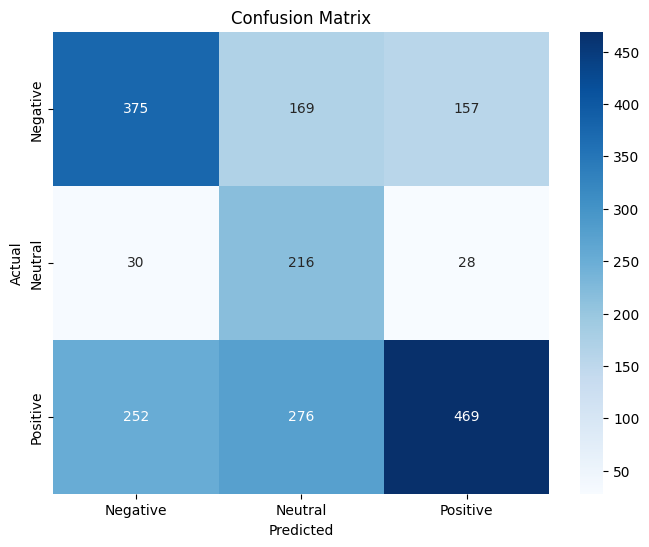

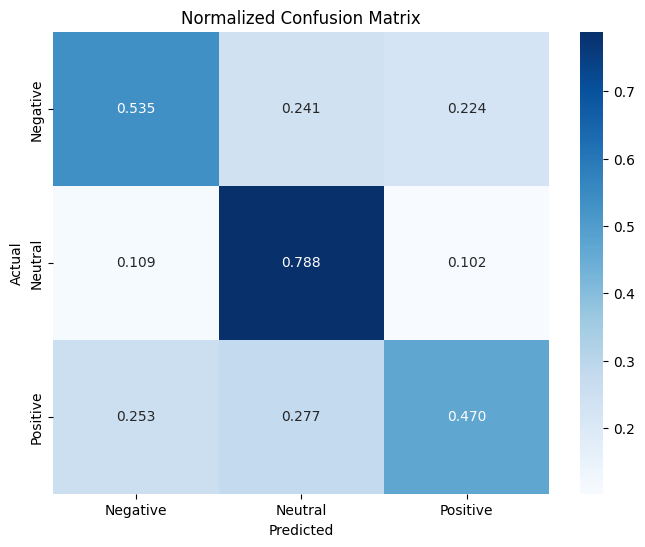

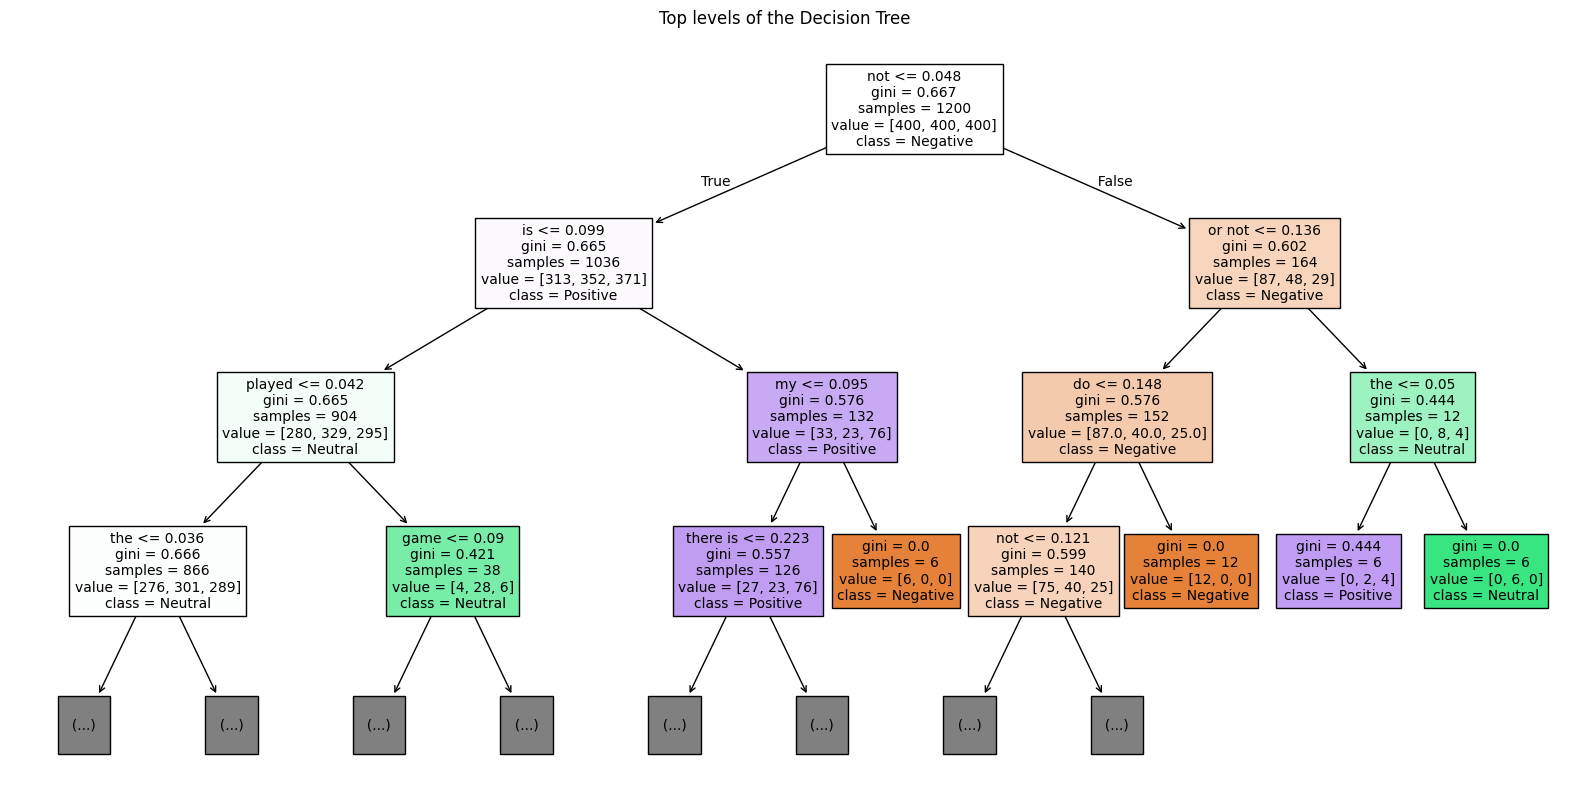


=== Top Decision Rules (text form) ===
|--- not <= 0.05
|   |--- is <= 0.10
|   |   |--- played <= 0.04
|   |   |   |--- the <= 0.04
|   |   |   |   |--- truncated branch of depth 40
|   |   |   |--- the >  0.04
|   |   |   |   |--- truncated branch of depth 46
|   |   |--- played >  0.04
|   |   |   |--- game <= 0.09
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- game >  0.09
|   |   |   |   |--- class: 2
|   |--- is >  0.10
|   |   |--- my <= 0.10
|   |   |   |--- there is <= 0.22
|   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- there is >  0.22
|   |   |   |   |--- class: 0
|   |   |--- my >  0.10
|   |   |   |--- class: 0
|--- not >  0.05
|   |--- or not <= 0.14
|   |   |--- do <= 0.15
|   |   |   |--- not <= 0.12
|   |   |   |   |--- truncated branch of depth 10
|   |   |   |--- not >  0.12
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- do >  0.15
|   |   |   |--- class: 0
|   |--- or not >  0.14
|   |   |--- the <= 0.05
|   |  

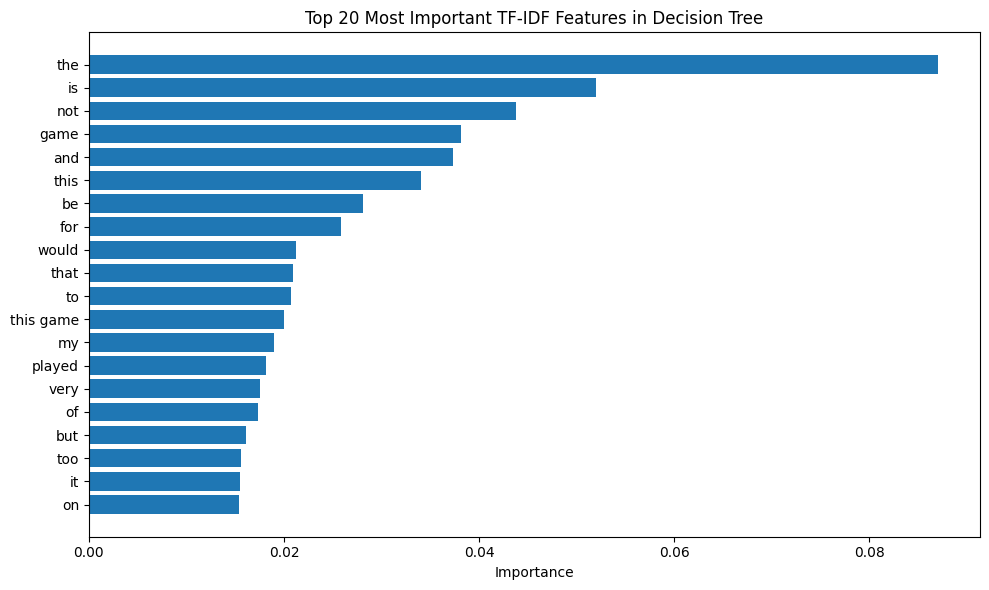

In [10]:
# Main function
def main():
    # Load and preprocess data
    train_filepath = '/content/train_df_balanced.csv'
    test_filepath = '/content/test_df_imbalanced.csv'
    X_train, y_train, X_test, y_test = load_data(train_filepath, test_filepath)
    X_train = X_train.apply(preprocess_text)
    X_test = X_test.apply(preprocess_text)

    # Define the pipeline
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ])

    # Grid search parameters
    param_grid = {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'vectorizer__max_features': [1000, 5000, 10000],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    # Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print("Best parameters found: ", grid_search.best_params_)

    # Cross-validation on best estimator
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
    print("Cross-validation scores: ", cv_scores)
    print("Mean cross-validation score: ", cv_scores.mean())

    # Predict and evaluate
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))

    # Save predictions
    output_filepath = '/content/DT_TF_predictions.csv'
    pd.DataFrame({'Text': X_test, 'Actual': y_test, 'Predicted': y_pred}).to_csv(output_filepath, index=False)
    print(f"Predictions saved to {output_filepath}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Normalized confusion matrix
    cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # ==== NEW: DECISION TREE VISUALIZATIONS ====
    best_tree = grid_search.best_estimator_.named_steps['classifier']
    vectorizer = grid_search.best_estimator_.named_steps['vectorizer']
    feature_names = vectorizer.get_feature_names_out()

    # 1. Plot top levels of decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(best_tree,
              feature_names=feature_names,
              class_names=['Negative', 'Neutral', 'Positive'],
              filled=True,
              max_depth=3,
              fontsize=10)
    plt.title("Top levels of the Decision Tree")
    plt.show()

    # 2. Print decision rules (text-based)
    print("\n=== Top Decision Rules (text form) ===")
    rules_text = export_text(best_tree, feature_names=list(feature_names), max_depth=3)
    print(rules_text)

    # 3. Plot most important features
    importances = best_tree.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    top_features = feature_names[indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, importances[indices])
    plt.xlabel("Importance")
    plt.title("Top 20 Most Important TF-IDF Features in Decision Tree")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()